# AmazonBook Dataset Overview and Description

**The AmazonBook dataset**

Is a bipartite graph dataset designed for tasks like recommendation systems and link prediction. It models interactions between users and books, making it ideal for studying relationships in purchase and review contexts.

**Key features of the dataset include:**

- **Nodes:** Represent users and books.

- **Edges:** Represent interactions between users and books, such as purchases or reviews.

- **Edge Features:** Include contextual data, such as purchase history and review information.

**Tasks Supported:**

1. **Link prediction** (predicting potential user-book interactions)

2. **recommendations** (identifying relevant books for users based on the graph structure).


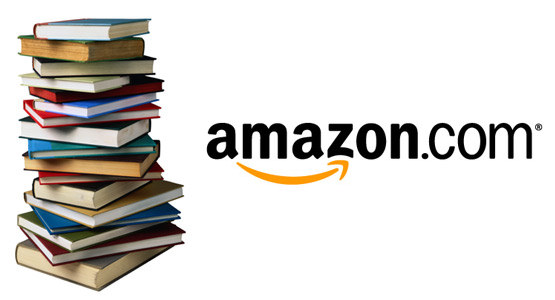



---



# Installing necessary dependencies

In [2]:
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.13.0+cu116.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.9 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.3/868.3 kB 3.1 MB/s eta 0:00:00
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=538974 sha256=8f282f04729e0a12fdfe207d3104eeabd95def7db7d33d51286cd538fe418ddb
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
ERROR: Operation cancelled by user




---



# Importing the Dataset

In [1]:
from torch_geometric.datasets import AmazonBook
dataset = AmazonBook(root='/tmp/AmazonBook')
data = dataset[0]
print(dataset[0])

HeteroData(
  user={ num_nodes=52643 },
  book={ num_nodes=91599 },
  (user, rates, book)={
    edge_index=[2, 2380730],
    edge_label_index=[2, 603378],
  },
  (book, rated_by, user)={ edge_index=[2, 2380730] }
)




---



# **1. Preprocessing**

In [2]:
data = dataset[0]

# Check if node features exist
if hasattr(data, 'x') and data.x is not None:
    print(f"Feature size: {data.x.shape}")
else:
    print("Feature size: No node features")

Feature size: No node features


**The data set seems to not have node feature.**

So not having node features in the AmazonBook dataset does not prevent us from satisfying our project requirements, as Graph Neural Networks (GNNs) can operate effectively using the structural properties of the graph and edge features heres why:

1. **Node Features Are Not Mandatory:**

-  Many GNNs, particularly those designed for link prediction or recommendation tasks which our dataset is one of them, focus on the edges (relationships) rather than node features.

- As GraphSAGE can aggregate neighborhood features, even if they are one-hot encoded or absent.
- As GGNN and CGNN can model the structural relationships in the graph using adjacency matrices and edge attributes.

2. **Rich Edge Features**

**The AmazonBook dataset includes edge features, such as:**

- Purchase interactions
- Review data

These edge features can carry significant contextual information for tasks like recommendation systems or link prediction. Models like GraphSAGE, GGNN, and CGNN can leverage edge features directly.



---


# Basic information

In [3]:
print(f"Number of graphs: {len(dataset)}")
print(f"Number of nodes: {dataset[0].num_nodes}")
print(f"Number of edges: {dataset[0].num_edges}")

Number of graphs: 1
Number of nodes: 144242
Number of edges: 4761460


# Inspect the Dataset

In [5]:
data = dataset[0]
print(data)

HeteroData(
  user={ num_nodes=52643 },
  book={ num_nodes=91599 },
  (user, rates, book)={
    edge_index=[2, 2380730],
    edge_label_index=[2, 603378],
  },
  (book, rated_by, user)={ edge_index=[2, 2380730] }
)


# Handling Missing Features

In [3]:
import torch
from torch_geometric.utils import degree

# Iterate over all edge types and calculate degree for each node type
for edge_type in data.edge_types:
    # Get source and target node types for the current edge type
    src_type, _, dst_type = edge_type

    # Get the edge index for the current edge type
    edge_index = data[edge_type].edge_index

    # Calculate degree for the target node type
    deg = degree(edge_index[1], num_nodes=data[dst_type].num_nodes)

    # Assign degree as node features for the target node type if no features are available
    if not hasattr(data[dst_type], 'x') or data[dst_type].x is None:
        data[dst_type].x = deg.view(-1, 1)  # Reshape to create feature vector per node


# Add placeholder edge features if not present for each edge type
for edge_type in data.edge_types:
    # Check if edge_attr exists before accessing it
    if not hasattr(data[edge_type], 'edge_attr') or data[edge_type].edge_attr is None:
        data[edge_type].edge_attr = torch.ones((data[edge_type].num_edges, 1))  # Placeholder scalar for edges

print(f"Node features shape (example): {data['user'].x.shape}")
print(f"Edge features shape (example): {data[data.edge_types[0]].edge_attr.shape}")

Node features shape (example): torch.Size([52643, 1])
Edge features shape (example): torch.Size([2380730, 1])


**1. Handling Missing Node Features:**

- Here we checks if the target node type (e.g., user or book) has any features assigned to it (data[dst_type].x). If the features are missing (None), we assign the degree of the node as its feature. The degree is calculated using the edge index for each edge type, and the result is reshaped into a feature vector for each node. This is a common method to create meaningful node features from the graph structure itself.

**2. Handling Missing Edge Features:**

- Similarly, for each edge type, we ensures that the edge features (data[edge_type].edge_attr) are present. If not, we assign a placeholder feature (a tensor of ones), which is essential when running GNN models since they typically expect edge features to exist.

In [4]:
print(f"Edge index for ('user', 'rates', 'book'):")
print(data[('user', 'rates', 'book')].edge_index)

print(f"Edge index for ('book', 'rated_by', 'user'):")
print(data[('book', 'rated_by', 'user')].edge_index)


Edge index for ('user', 'rates', 'book'):
tensor([[    0,     0,     0,  ..., 52642, 52642, 52642],
        [    0,     1,     2,  ..., 23186, 10690, 10874]])
Edge index for ('book', 'rated_by', 'user'):
tensor([[    0,     1,     2,  ..., 23186, 10690, 10874],
        [    0,     0,     0,  ..., 52642, 52642, 52642]])


# Normalizing and Splitting the Dataset

- **As the dataset is large we need to handle edge splitting so we will use scalable approach(smaller chunks) that minimizes memory usage and avoids excessive processing times.**

In [5]:
from torch_geometric.utils import train_test_split_edges
from torch_geometric.data import Data
import torch
import os

# Define a function to split edges for a subset of data
def split_edges_in_subset(data, edge_type, batch_size=100):
    # Create a temporary directory to store split results
    os.makedirs('split_edges', exist_ok=True)

    # Process edges in batches
    for i in range(0, data[edge_type].num_edges, batch_size):
        batch_edge_index = data[edge_type].edge_index[:, i:i + batch_size]
        batch_edge_attr = data[edge_type].edge_attr[i:i + batch_size] if data[edge_type].edge_attr is not None else None

        homogeneous_data = Data(edge_index=batch_edge_index, edge_attr=batch_edge_attr)

        # Split the edges into train/val/test
        split_edges = train_test_split_edges(homogeneous_data)

        # Save the split edges for this batch
        save_path = f'split_edges/{edge_type}_{i}.pt'
        torch.save(split_edges, save_path)  # Save split edges to disk

        print(f"Processed and saved batch {i} for {edge_type}")

# Iterate over each edge type in the dataset and process them in chunks
for edge_type in data.edge_types:
    print(f"Processing edge type: {edge_type}")
    split_edges_in_subset(data, edge_type, batch_size=100)  # Adjust batch size based on your memory



Processing edge type: ('user', 'rates', 'book')
Processed and saved batch 0 for ('user', 'rates', 'book')
Processed and saved batch 100 for ('user', 'rates', 'book')
Processed and saved batch 200 for ('user', 'rates', 'book')
Processed and saved batch 300 for ('user', 'rates', 'book')
Processed and saved batch 400 for ('user', 'rates', 'book')
Processed and saved batch 500 for ('user', 'rates', 'book')
Processed and saved batch 600 for ('user', 'rates', 'book')
Processed and saved batch 700 for ('user', 'rates', 'book')
Processed and saved batch 800 for ('user', 'rates', 'book')
Processed and saved batch 900 for ('user', 'rates', 'book')


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/storage.py:452: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index', 'edge_attr'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


Processed and saved batch 1000 for ('user', 'rates', 'book')
Processed and saved batch 1100 for ('user', 'rates', 'book')
Processed and saved batch 1200 for ('user', 'rates', 'book')
Processed and saved batch 1300 for ('user', 'rates', 'book')
Processed and saved batch 1400 for ('user', 'rates', 'book')
Processed and saved batch 1500 for ('user', 'rates', 'book')
Processed and saved batch 1600 for ('user', 'rates', 'book')
Processed and saved batch 1700 for ('user', 'rates', 'book')
Processed and saved batch 1800 for ('user', 'rates', 'book')
Processed and saved batch 1900 for ('user', 'rates', 'book')
Processed and saved batch 2000 for ('user', 'rates', 'book')
Processed and saved batch 2100 for ('user', 'rates', 'book')
Processed and saved batch 2200 for ('user', 'rates', 'book')
Processed and saved batch 2300 for ('user', 'rates', 'book')
Processed and saved batch 2400 for ('user', 'rates', 'book')
Processed and saved batch 2500 for ('user', 'rates', 'book')
Processed and saved batc

KeyboardInterrupt: 

**1. Resumption Check:**

Before processing each batch, the script checks if the file for that batch already exists this avoids redundant computations.

**2. Saving Each Batch:**

After splitting the edges for a batch, the result is saved immediately to disk using torch.save. Each batch is saved as a .pt file in the split_edges directory.

**3. Processing Remaining Batches:**

If an interruption occurs, re-running the script will automatically skip completed batches and continue from the last unprocessed batch.

- **Number of Edges**

In [ ]:
for edge_type in data.edge_types:
    print(f"Edge type {edge_type} has {data[edge_type].num_edges} edges.")


Edge type ('user', 'rates', 'book') has 2380730 edges.
Edge type ('book', 'rated_by', 'user') has 2380730 edges.


- **Calculating the total batches**

In [ ]:
import math
for edge_type in data.edge_types:
    total_edges = data[edge_type].num_edges
    total_batches = math.ceil(total_edges / 100)
    print(f"Total batches for edge type {edge_type}: {total_batches}")

Total batches for edge type ('user', 'rates', 'book'): 23808
Total batches for edge type ('book', 'rated_by', 'user'): 23808
